In [11]:
from glob import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pydicom
from pydicom import dcmread
import os.path as osp
import os
import torch
from einops import rearrange
import numpy as np
from rt_utils.image_helper import get_pixel_to_patient_transformation_matrix, apply_transformation_to_3d_points

## Utility Functions

In [2]:
def get_transformation_matrix(input):
    # load all images into series data
    # series_data = []
    # for file in glob(f"{path}/*.dcm"):
    #     ds = dcmread(file)
    #     series_data.append(ds)
    print(input)
    dicoms = sorted([osp.join(input, i) for i in os.listdir(input) if i.endswith('dcm') or i.endswith('dicom')])
    dicoms = [pydicom.dcmread(d) for d in dicoms]
    #transformation matrix that maps 2D pixels to 3D coordinates
    transformation_matrix = get_pixel_to_patient_transformation_matrix(dicoms)
 
    return transformation_matrix

def get_img_list(path):
    series_data = []
    for file in glob(f"{path}/*.dcm"):
        ds = dcmread(file)
        img1 = ds.pixel_array
        series_data.append(img1)

    return series_data

# input dcm data, index/specific location (0-19), matrix transformation
# return patient coordinates
def transform_3D(dcm_data, index, mat):
    data = dcm_data.pixel_array
    h,w = data.shape
    x = np.arange(w)
    y = np.arange(h)
    x, y = np.meshgrid(x, y)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    points = np.concatenate((x, y), axis=1)
    # ys, xs = np.where(np.ones((h,w)))
    # coords = np.concatenate((ys.reshape(-1, 1), xs.reshape(-1, 1)), axis=1)
    # extended_coords = np.concatenate((coords, np.ones((h * w, 1)) * index), axis=1)
    # y_values = points[:, 1].tolist()
    p = np.concatenate((points, np.full((len(points), 1), index)), axis=1)
    patient_coords = apply_transformation_to_3d_points(p, mat)
    #patient_coords = patient_coords.reshape(h, w, patient_coords.shape[-1])
    print (patient_coords)
    return (patient_coords, points, data)

def print_3D(patient_coords_list):
    fig = plt.figure(figsize=(10, 20))
    ax = fig.add_subplot(projection='3d')
    # count = 0
    for (patient_coord, points, data) in patient_coords_list:
        data = ((data/data.max())).flatten()
        indice = np.random.choice(len(points), 100000)
        colors = [[c, c, c] for c in data[indice]]
        # if count == 0:
        #     count += 1
        #     colors = [[c, 0, 0] for c in data[indice]]
        # else:
        #     count -= 1
        #     colors = [[0, c, 0] for c in data[indice]]
        ax.scatter(patient_coord[indice,0], patient_coord[indice,1], patient_coord[indice,2], color = colors, alpha=0.1)
    ax.view_init(elev=30, azim=45)


## T2 Conversion

data/t2/
IM-6392-0014.dcm
[[-111.78468323  -73.55931854  -82.72187805]
 [-111.15968323  -73.55931854  -82.72187805]
 [-110.53468323  -73.55931854  -82.72187805]
 ...
 [  86.34031677  125.81568146  -82.72187805]
 [  86.96531677  125.81568146  -82.72187805]
 [  87.59031677  125.81568146  -82.72187805]]
IM-6392-0015.dcm
[[-111.78468323  -73.55931854  -79.12187791]
 [-111.15968323  -73.55931854  -79.12187791]
 [-110.53468323  -73.55931854  -79.12187791]
 ...
 [  86.34031677  125.81568146  -79.12187791]
 [  86.96531677  125.81568146  -79.12187791]
 [  87.59031677  125.81568146  -79.12187791]]
IM-6392-0001.dcm
[[-111.78468323  -73.55931854  -75.52187777]
 [-111.15968323  -73.55931854  -75.52187777]
 [-110.53468323  -73.55931854  -75.52187777]
 ...
 [  86.34031677  125.81568146  -75.52187777]
 [  86.96531677  125.81568146  -75.52187777]
 [  87.59031677  125.81568146  -75.52187777]]
IM-6392-0017.dcm
[[-111.78468323  -73.55931854  -71.92187762]
 [-111.15968323  -73.55931854  -71.92187762]
 [-11

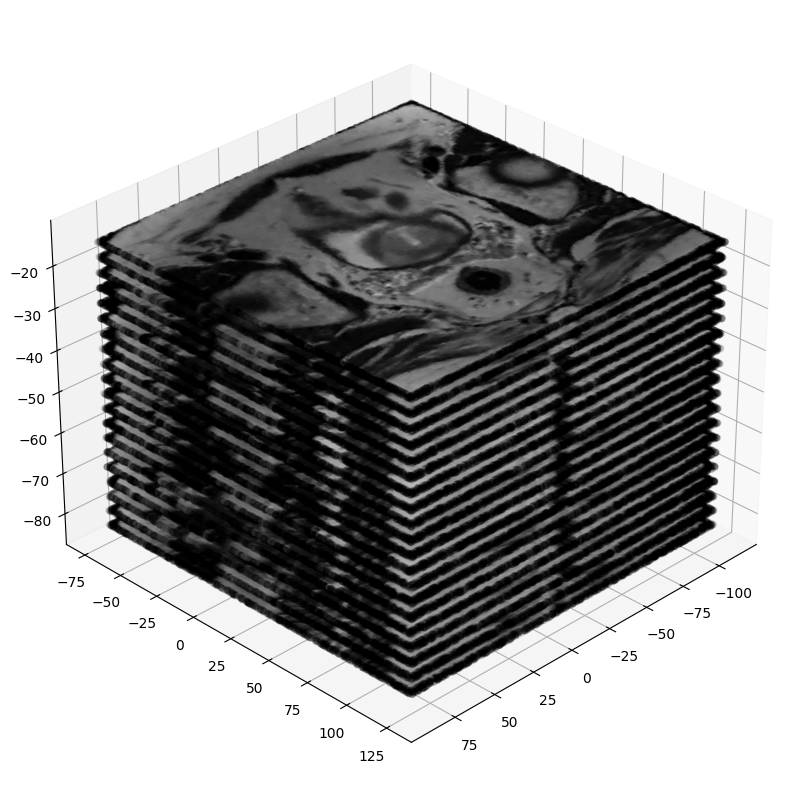

In [3]:
directory_path = 'data/t2/'
t2_mat = get_transformation_matrix('data/t2/')
new_t2_mat = np.array(t2_mat)

# Loop through the files in the directory
t2_patient_coords_list = []
for i,filename in enumerate(os.listdir(directory_path)):
    # Construct the full path to the file
    print(filename)
    full_path = os.path.join(directory_path, filename)

    t2_img1_dcm = pydicom.dcmread(full_path)
    t2_img1 = t2_img1_dcm.pixel_array

    patient_coords = transform_3D(t2_img1_dcm, i, new_t2_mat)
    t2_patient_coords_list.append(patient_coords)
print (len(t2_patient_coords_list))
print_3D(t2_patient_coords_list)

## Ktrans Conversion

data/ktrans/
slice-005.dcm
[[-141.78468323 -103.55931854  -82.72187805]
 [-140.15968323 -103.55931854  -82.72187805]
 [-138.53468323 -103.55931854  -82.72187805]
 ...
 [ 113.34031677  154.81568146  -82.72187805]
 [ 114.96531677  154.81568146  -82.72187805]
 [ 116.59031677  154.81568146  -82.72187805]]
slice-011.dcm
[[-141.78468323 -103.55931854  -79.12187815]
 [-140.15968323 -103.55931854  -79.12187815]
 [-138.53468323 -103.55931854  -79.12187815]
 ...
 [ 113.34031677  154.81568146  -79.12187815]
 [ 114.96531677  154.81568146  -79.12187815]
 [ 116.59031677  154.81568146  -79.12187815]]
slice-010.dcm
[[-141.78468323 -103.55931854  -75.52187824]
 [-140.15968323 -103.55931854  -75.52187824]
 [-138.53468323 -103.55931854  -75.52187824]
 ...
 [ 113.34031677  154.81568146  -75.52187824]
 [ 114.96531677  154.81568146  -75.52187824]
 [ 116.59031677  154.81568146  -75.52187824]]
slice-004.dcm
[[-141.78468323 -103.55931854  -71.92187834]
 [-140.15968323 -103.55931854  -71.92187834]
 [-138.534683

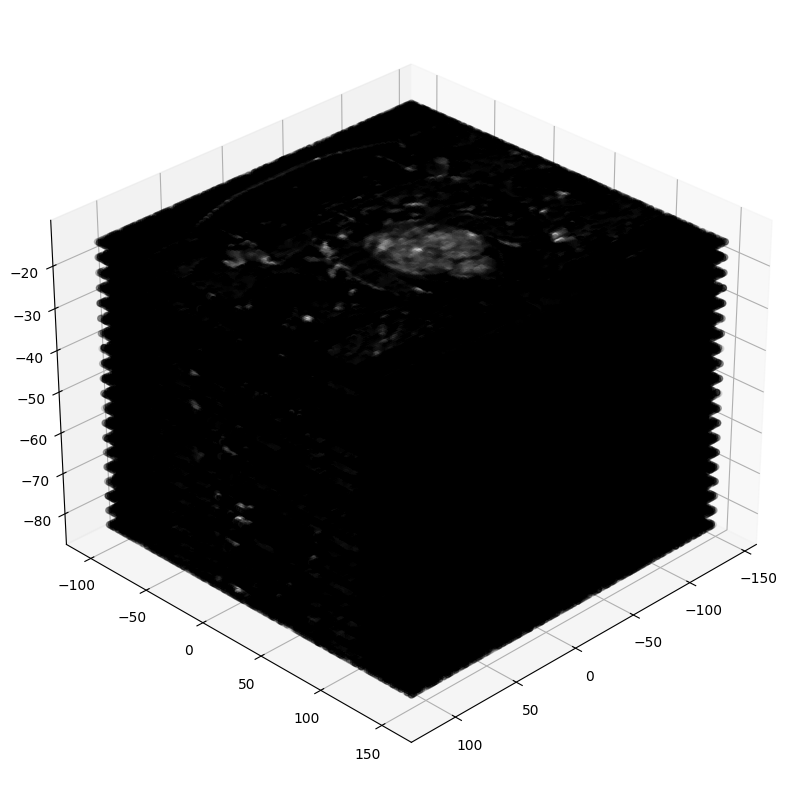

In [4]:
directory_path = 'data/ktrans/'
ktrans_mat = get_transformation_matrix('data/ktrans/')
new_ktrans_mat = np.array(ktrans_mat)

# Loop through the files in the directory
ktrans_patient_coords_list = []
for i,filename in enumerate(os.listdir(directory_path)):
    # Construct the full path to the file
    print(filename)
    full_path = os.path.join(directory_path, filename)

    ktrans_img1_dcm = pydicom.dcmread(full_path)
    ktrans_img1 = ktrans_img1_dcm.pixel_array

    patient_coords = transform_3D(ktrans_img1_dcm, i, new_ktrans_mat)
    ktrans_patient_coords_list.append(patient_coords)

print (len(ktrans_patient_coords_list))
print_3D(ktrans_patient_coords_list)

## Visualize

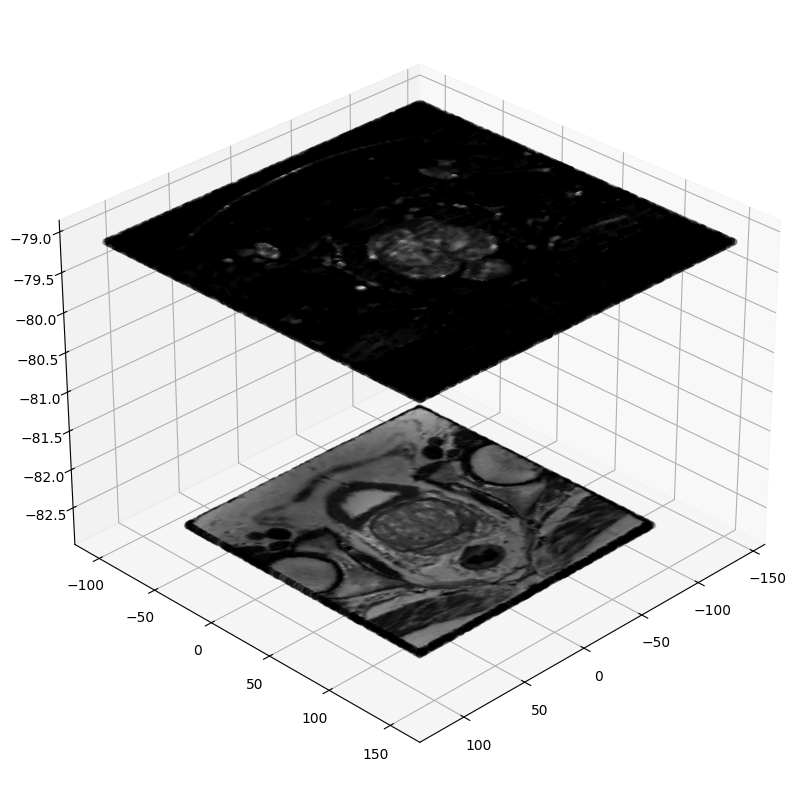

In [5]:
t2_and_ktrans_patient_coords_list = []
t2_and_ktrans_patient_coords_list.append(t2_patient_coords_list[0])
t2_and_ktrans_patient_coords_list.append(ktrans_patient_coords_list[1])

print_3D(t2_and_ktrans_patient_coords_list)

## Interpolation: Toy Example

In [7]:
import torch
from einops import rearrange

data = torch.tensor([[1,2], [3,4]]).float()
print(data)
data = rearrange(data, "h w -> 1 1 h w")
print(data.shape)
print(data)

y, x = torch.meshgrid(torch.tensor([-1, -0.5, 0, 0.5, 1]), torch.tensor([-1, -0.5, 0, 0.5, 1]))


print("y = ", y)
print('-----------')
print("x = ", x)


# 3x3x2
xy = torch.cat((x.unsqueeze(dim=-1), y.unsqueeze(dim=-1)), dim=2).float()


# 1x3x3x2
xy = rearrange(xy, 'h w d -> 1 h w d', d=2)

# print(xy)



tensor([[1., 2.],
        [3., 4.]])
torch.Size([1, 1, 2, 2])
tensor([[[[1., 2.],
          [3., 4.]]]])
y =  tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-0.5000, -0.5000, -0.5000, -0.5000, -0.5000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.5000,  0.5000,  0.5000,  0.5000,  0.5000],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000]])
-----------
x =  tensor([[-1.0000, -0.5000,  0.0000,  0.5000,  1.0000],
        [-1.0000, -0.5000,  0.0000,  0.5000,  1.0000],
        [-1.0000, -0.5000,  0.0000,  0.5000,  1.0000],
        [-1.0000, -0.5000,  0.0000,  0.5000,  1.0000],
        [-1.0000, -0.5000,  0.0000,  0.5000,  1.0000]])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
torch.nn.functional.grid_sample(data, xy, align_corners=True)

tensor([[[[1.0000, 1.2500, 1.5000, 1.7500, 2.0000],
          [1.5000, 1.7500, 2.0000, 2.2500, 2.5000],
          [2.0000, 2.2500, 2.5000, 2.7500, 3.0000],
          [2.5000, 2.7500, 3.0000, 3.2500, 3.5000],
          [3.0000, 3.2500, 3.5000, 3.7500, 4.0000]]]])

In [9]:
# 3 * 3

data = torch.tensor([[1,2,3], [4,5,6], [7,8,9]]).float()
data = rearrange(data, "h w -> 1 1 h w")
print(data.shape)

# makes a 5*5 matrix with positions from -1 to 1, refer to middle as (0,0)
y, x = torch.meshgrid(torch.tensor([-1, -0.5, 0, 0.5, 1]), torch.tensor([-1, -0.5, 0, 0.5, 1]))

xy = torch.cat((x.unsqueeze(dim=-1), y.unsqueeze(dim=-1)), dim = 2).float()
xy = rearrange(xy, 'h w d -> 1 h w d', d=2)

print(xy)

torch.Size([1, 1, 3, 3])
tensor([[[[-1.0000, -1.0000],
          [-0.5000, -1.0000],
          [ 0.0000, -1.0000],
          [ 0.5000, -1.0000],
          [ 1.0000, -1.0000]],

         [[-1.0000, -0.5000],
          [-0.5000, -0.5000],
          [ 0.0000, -0.5000],
          [ 0.5000, -0.5000],
          [ 1.0000, -0.5000]],

         [[-1.0000,  0.0000],
          [-0.5000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.5000,  0.0000],
          [ 1.0000,  0.0000]],

         [[-1.0000,  0.5000],
          [-0.5000,  0.5000],
          [ 0.0000,  0.5000],
          [ 0.5000,  0.5000],
          [ 1.0000,  0.5000]],

         [[-1.0000,  1.0000],
          [-0.5000,  1.0000],
          [ 0.0000,  1.0000],
          [ 0.5000,  1.0000],
          [ 1.0000,  1.0000]]]])


In [17]:
new_data = torch.nn.functional.grid_sample(data, xy, align_corners=True)
new_data = rearrange(new_data, "1 1 h w -> h w")
print(new_data)

tensor([[1.0000, 1.5000, 2.0000, 2.5000, 3.0000],
        [2.5000, 3.0000, 3.5000, 4.0000, 4.5000],
        [4.0000, 4.5000, 5.0000, 5.5000, 6.0000],
        [5.5000, 6.0000, 6.5000, 7.0000, 7.5000],
        [7.0000, 7.5000, 8.0000, 8.5000, 9.0000]])


## Interpolation: T2 and KTrans

In [9]:
# (patient_coord, points, data)  patient-coordinates: the legit coordinates
# data: intensities at each coordinate, was used for colors
# points: list of all points from (0,0) to (320,320) for T2, (0,0) to (159,159) for ktrans
print(t2_patient_coords_list[0][2])

# MRI
def interpolate_t2_to_ktrans_size(t2_tuple, ktrans_tuple):
    t2_data = torch.tensor(t2_tuple[2].tolist()).float()
    t2_data = rearrange(t2_data, "h w -> 1 1 h w")

    # makes a ktrans*ktrans matrix with positions from -1 to 1, refer to middle as (0,0)
    # Define the number of points you want between -1 and 1
    num_points = int(len(ktrans_tuple[1])** 0.5)

    # Generate the list with even increments
    increment = 2 / (num_points - 1) if num_points > 1 else 0
    result_list = [-1 + i * increment for i in range(num_points)]

    y_tensor = torch.tensor(result_list)
    x_tensor = torch.tensor(result_list)
    # x_tensor
    y, x = torch.meshgrid(y_tensor, x_tensor)

    xy = torch.cat((x.unsqueeze(dim=-1), y.unsqueeze(dim=-1)), dim = 2).float()
    xy = rearrange(xy, 'h w d -> 1 h w d', d=2)

    # print(xy)

    new_data = torch.nn.functional.grid_sample(t2_data, xy, align_corners=True)
    new_data = rearrange(new_data, "1 1 h w -> h w")
    return new_data

[[0 0 0 ... 0 0 0]
 [0 2 0 ... 0 2 1]
 [0 1 0 ... 0 0 3]
 ...
 [0 0 0 ... 0 3 2]
 [0 0 0 ... 0 0 2]
 [0 0 0 ... 0 1 0]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


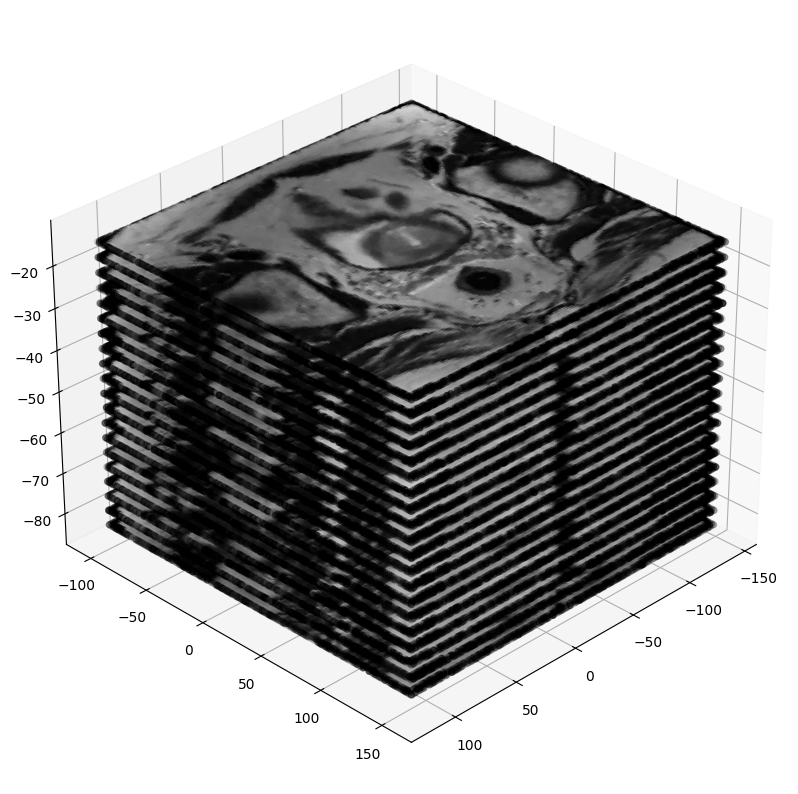

In [12]:
t2_and_ktrans_patient_coords_list = []
for i in range(len(t2_patient_coords_list)):
    new_data = interpolate_t2_to_ktrans_size(t2_patient_coords_list[i], ktrans_patient_coords_list[i])
    t2_patient_coords_list[i] = (ktrans_patient_coords_list[i][0], ktrans_patient_coords_list[i][1], new_data)
    t2_and_ktrans_patient_coords_list.append(t2_patient_coords_list[i])

print_3D(t2_and_ktrans_patient_coords_list)